# Machine Learning and Content Analytics – Mini Project

# Offensive language and hate speech detection 
---
> Students: `Arkoumani Georgia - p2822104` `Poulou Myrto - p2822129` `Koutsodimitropoulou Anastasia - p2822119` `Zaragka Eftychia - p2822112` <br />
> Professor: Haris Papageorgiou (xaris@ilsp.gr) <br />
> Assistant responsible for this assignment: George Perakis (gperakis@aueb.gr) <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> Date: 28/08/2022

In [3]:
import zipfile
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
from utils import export_model, import_model

from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
zf = zipfile.ZipFile('more_cleaned_df.zip') 
df = pd.read_csv(zf.open('more_cleaned_df.csv'))

df = df.dropna()
df

,category,lemmatized
0,0,yes sort remind eld lady play movie titanic te...
1,0,lady buy gun learn use effectively kill mother...
2,0,amazing dad not forget girl crushs girl mom as...
3,0,delon love turkey brave turk indian muslim sha...
4,0,here thing person earth decide not matter feel...
...,...,...
1381257,1,know woman single
1381258,1,woman want mother say want patriarchal society
1381259,1,woman submissive man
1381260,1,woman essentially childlike unable understand ...


### Display most frequent words in general
##### Param search_df might be:
---
 - **0**: Non offensive words
 - **1**: Offensive words
 - **None**: Neutral

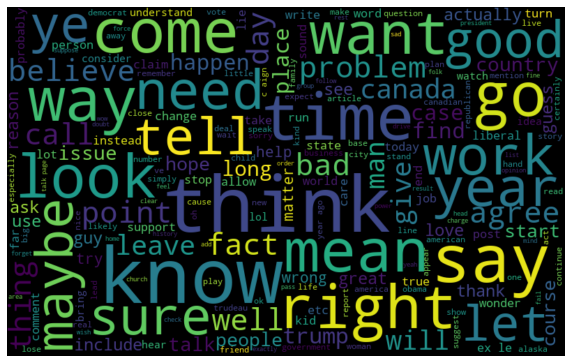

In [3]:
search_df = None

search_df = [0, 1] if not search_df else [search_df]
all_words = ' '.join([text for text in df['lemmatized'][df['category'].isin(search_df)]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

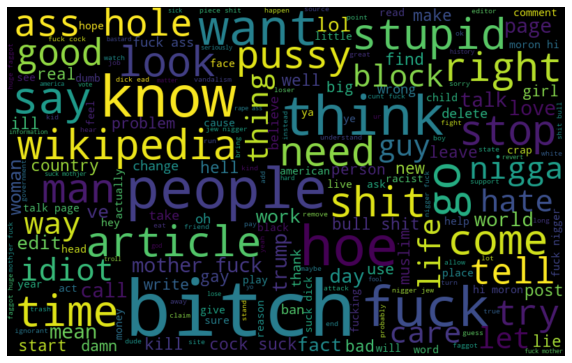

In [4]:
search_df = 1

search_df = [0, 1] if not search_df else [search_df]
all_words = ' '.join([text for text in df['lemmatized'][df['category'].isin(search_df)]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Count Vectorizer applied to all data

In [5]:
# ================================ Bag of Words Vectorizer ================================
# Max features: Select only top 1000 terms ordered by term frequency across the corpus
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['lemmatized'])
# BoW DataFrame representation
bow_array = bow.toarray()
bow_df = pd.DataFrame(data=bow_array, columns=bow_vectorizer.get_feature_names_out())
bow_df

,ability,able,abortion,absolutely,abuse,accept,access,accord,account,act,...,wp,write,wrong,ya,yeah,year,yes,young,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1381258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1381259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1381260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


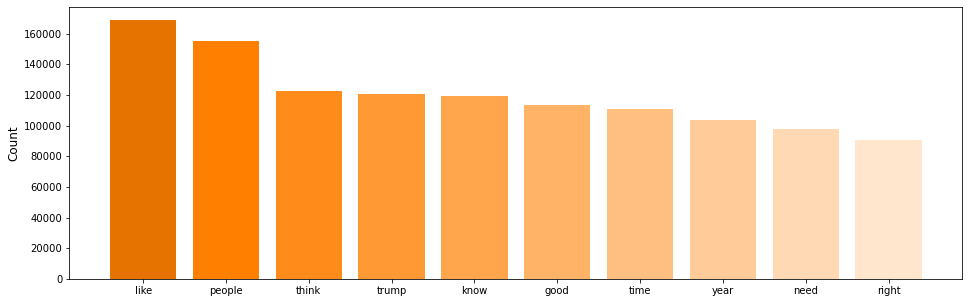

In [6]:
# Display top 10 most frequent words based on BoW
extracted_features = bow_df

b = extracted_features.sum()
e = pd.DataFrame({'Words': b.keys().tolist(), 'Count': b.values.tolist()})
# selecting top 10 most frequent words
e = e.nlargest(columns="Count", n=10)
plt.figure(figsize=(16, 5))
# Plot the data:
my_colors = ['#e67300', '#ff8000', '#ff8c1a', '#ff9933', '#ffa64d', '#ffb366', '#ffbf80', '#ffcc99', '#ffd9b3', '#ffe6cc', '#fff2e6']
plt.bar(e['Words'], e['Count'], color=my_colors)
plt.ylabel('Count', fontsize=12)
plt.show()

### TF-IDF applied to all data

In [7]:
# ================================ TF-IDF Vectorizer ================================
# Max features: Select only top 1000 terms ordered by term frequency across the corpus
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['lemmatized'])
# TF-IDF DataFrame representation
tfidf_array = tfidf.toarray()
tfidf_df = pd.DataFrame(data=tfidf_array, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,ability,able,abortion,absolutely,abuse,accept,access,accord,account,act,...,wp,write,wrong,ya,yeah,year,yes,young,youtube,zero
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.276749,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.245908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381257,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1381258,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1381259,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1381260,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


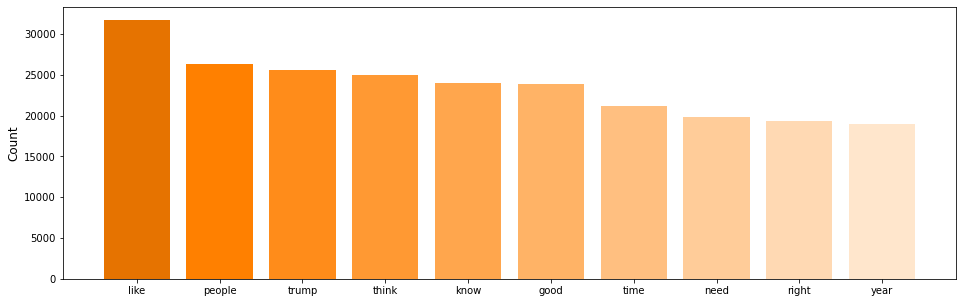

In [8]:
# Display top 10 most frequent words based on TF-IDF
extracted_features = tfidf_df

b = extracted_features.sum()
e = pd.DataFrame({'Words': b.keys().tolist(), 'Count': b.values.tolist()})
# selecting top 10 most frequent words
e = e.nlargest(columns="Count", n=10)
plt.figure(figsize=(16, 5))
# Plot the data:
my_colors = ['#e67300', '#ff8000', '#ff8c1a', '#ff9933', '#ffa64d', '#ffb366', '#ffbf80', '#ffcc99', '#ffd9b3', '#ffe6cc', '#fff2e6']
plt.bar(e['Words'], e['Count'], color=my_colors)
plt.ylabel('Count', fontsize=12)
plt.show()

In the following section it is specified how the Logistic Regression classifier responds to a Bag of Words and a TF-IDF vectorization respectively.

In [9]:
lreg = LogisticRegression(max_iter=10000)

In [10]:
# splitting data into training and validation set
xtrain_bow, xtest_bow, ytrain, ytest = train_test_split(bow, df['category'], random_state=42, test_size=0.3)

In [11]:
lreg.fit(xtrain_bow, ytrain)  # training the model

LogisticRegression(max_iter=10000)

In [12]:
predictions = lreg.predict(xtest_bow)
print('Test set score:', f1_score(ytest, predictions))

Test set score: 0.5154286770140428


In [13]:
from sklearn.metrics import roc_auc_score
print('[Logistic Regression] test set score:', roc_auc_score(ytest, lreg.predict_proba(xtest_bow)[:, 1]))

[Logistic Regression] test set score: 0.8889743011839601


In [14]:
# splitting data into training and validation set
xtrain_tfidf, xtest_tfidf, ytrain, ytest = train_test_split(tfidf, df['category'], random_state=42, test_size=0.3)

In [15]:
lreg.fit(xtrain_tfidf, ytrain) # training the model

LogisticRegression(max_iter=10000)

In [16]:
from sklearn.metrics import roc_auc_score
print('[Logistic Regression] test set score:', roc_auc_score(ytest, lreg.predict_proba(xtest_tfidf)[:, 1]))

[Logistic Regression] test set score: 0.8950357257952739


In [17]:
from sklearn.utils import shuffle

# Extra shuffle (can be skipped because it is performed in StratifiedKFold)
df = shuffle(df)

In [18]:
df_positive = df[df['category']==1]
df_negative = df[df['category']==0]

In [19]:
# The chunk size of each DataFrame is initialized. If chunk size exceeds the available positive records
# system retrieves as many positive records as can be found.
data_length = 500000

chunk_size = int(data_length / 2)

df_positive_no = chunk_size if len(df_positive) > chunk_size else len(df_positive)

In [20]:
# Here both sub-DataFrames repeat the process of shuffling.
df_negative = shuffle(df_negative)
df_negative = df_negative[:chunk_size]

df_positive = shuffle(df_positive)
df_positive = df_positive[:df_positive_no] 

In [21]:
frames = [df_positive, df_negative]

df = pd.concat(frames, ignore_index=True)

df = shuffle(df)

df

,category,lemmatized
284762,0,elagabalus say well
181057,0,ignore question favour doctor will not carry a...
214570,0,al gore buy beach house keep boat roof ocean n...
153805,0,yes like missive corrupt un tell not measure l...
150666,0,suppose catholic support abortion murder helpl...
...,...,...
266580,0,shanahans team right want head coach think pla...
204506,0,true point student not sat good math go school...
161028,0,diverdave say
211777,0,semantic


In [22]:
# Pass an int for reproducible output across multiple function calls
xtrain, xtest, ytrain, ytest = train_test_split(df['lemmatized'], df['category'], random_state=42, test_size=0.3)

In [23]:
# max_df : When building the vocabulary ignore terms that have a document
# frequency strictly higher than the given threshold
# min_df : When building the vocabulary ignore terms that have a document
# frequency strictly lower than the given threshold
# max_features: Select only top 1000 terms ordered by term frequency across the corpus
# stop_words : If 'english', a built-in stop word list for English is used
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow_features_train = bow_vectorizer.fit_transform(xtrain)
bow_features_test = bow_vectorizer.transform(xtest)
print(bow_features_train.shape, bow_features_test.shape)

(210254, 1000) (90110, 1000)


In [24]:
# max_df : When building the vocabulary ignore terms that have a document
# frequency strictly higher than the given threshold
# min_df : When building the vocabulary ignore terms that have a document
# frequency strictly lower than the given threshold
# max_features: Select only top 1000 terms ordered by term frequency across the corpus
# stop_words : If a string, it is passed to _check_stop_list and the appropriate stop
# list is returned. 'english' is currently the only supported string
# value.
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf_features_train = tfidf_vectorizer.fit_transform(xtrain)
tfidf_features_test = tfidf_vectorizer.transform(xtest)
print(tfidf_features_train.shape, tfidf_features_test.shape)

(210254, 1000) (90110, 1000)


In [25]:
import tables
from tables import CONF_MATRIX_TABLE, SCORES_TABLE

In [26]:
tables.display(CONF_MATRIX_TABLE)

### SMOTE

In [27]:
df_positive = df[df['category']==1]
df_negative = df[df['category']==0]

# It is calculated the number of positive records to be created through augmentation process.
aug_sentences_to_build_no = len(df_negative) - len(df_positive)

In [28]:
# Augmentation Process
# If there is no record to get created an Exception is raised in order to stop the execution.
# If there are records to be created system proceeds to their creation.
if aug_sentences_to_build_no <= 0:
    raise Exception('No need for SMOTE.')
else:
    print('SMOTE is applied.')
    from imblearn.over_sampling import SMOTE
    from collections import Counter

# summarize class distribution
counter = Counter(ytrain)
print(counter)
# transform the dataset
oversample = SMOTE()
bow_features_train_sm, ytrain_sm = oversample.fit_resample(bow_features_train, ytrain)
# summarize the new class distribution (BoW)
counter = Counter(ytrain_sm)
print(counter)
tfidf_features_train_sm, ytrain_sm = oversample.fit_resample(tfidf_features_train, ytrain)
# summarize the new class distribution (TF_IDF)
counter = Counter(ytrain_sm)
print(counter)

SMOTE is applied.
Counter({0: 174993, 1: 35261})
Counter({1: 174993, 0: 174993})
Counter({1: 174993, 0: 174993})


[Logistic Regression] test set score: 0.9280118401732503
[Multinomial Naive Bayes] test set score: 0.9138012809947446
[Linear Support Vector Classifier] test set score: 0.9293109804355315
[K Neighbors Classifier] test set score: 0.8257668084550471


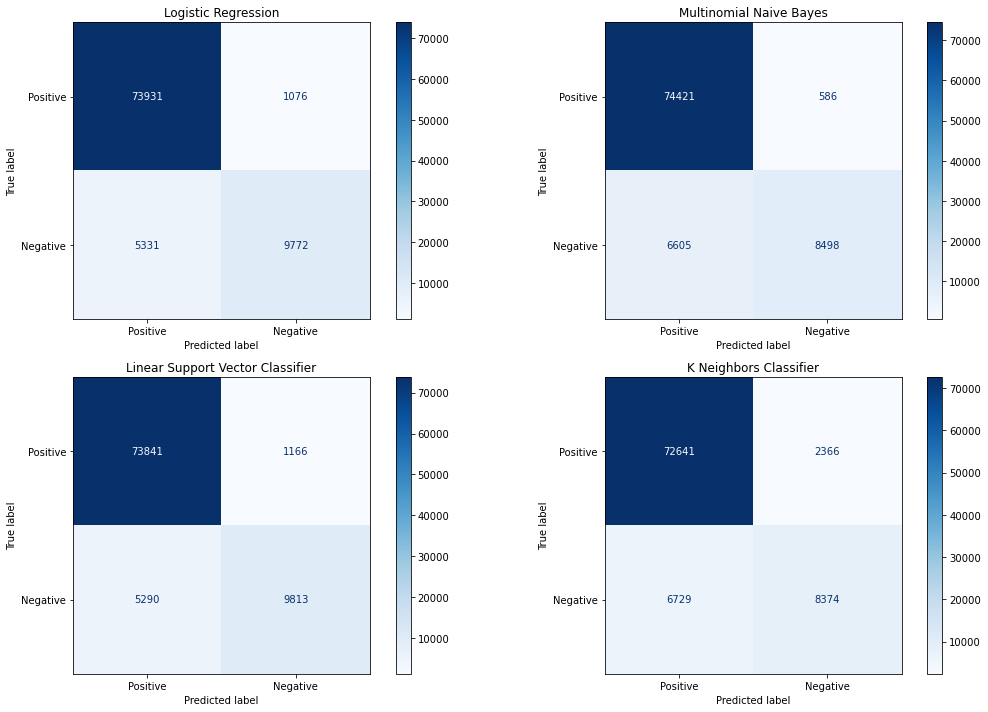

In [29]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV

LinearSVCPipe = make_pipeline(CalibratedClassifierCV(LinearSVC()))

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear Support Vector Classifier": LinearSVCPipe,
    "K Neighbors Classifier": KNeighborsClassifier()
}

from sklearn.metrics import roc_auc_score

for clf_name, clf in classifiers.items():
    clf.fit(tfidf_features_train, ytrain)
    print(f'[{clf_name}] test set score:', roc_auc_score(ytest, clf.predict_proba(tfidf_features_test)[:, 1]))

from sklearn.metrics import plot_confusion_matrix

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for (clf_name, clf), ax in zip(classifiers.items(), axes.flatten()):
    plot_confusion_matrix(
        clf, 
        tfidf_features_test, 
        ytest,
        ax=ax,
        cmap='Blues',
        display_labels=['Positive', 'Negative'])
    ax.title.set_text(clf_name)
plt.tight_layout()  
plt.show()

In [34]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [35]:
# [-- Hyperparameters Sol --]
pipe = Pipeline(steps=[
    # ('smote', SMOTE(random_state=11)),
    # ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

grid_vals = [
    {'classifier': [LinearSVC()]},
    {'classifier': [LogisticRegression()]},
    {'classifier': [MultinomialNB()]},
    {'classifier': [KNeighborsClassifier()]},
]

In [36]:
from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=11
)

In [37]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid_vals,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=10
)

grid_search.fit(tfidf_features_train, ytrain)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
test_score = grid_search.score(tfidf_features_test, ytest)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}\n')

print(f'Best params: {best_params}\n')

import pprint
print('All grid\'s scores: \n')
print('----------------------')
pprint.pprint(grid_search.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Cross-validation score: 0.9256754269883255
Test score: 0.9293280871396848

Best params: {'classifier': LinearSVC()}

All grid's scores: 

----------------------
{'mean_fit_time': array([2.19804827, 2.06400569, 0.08510598, 0.08410875]),
 'mean_score_time': array([3.88960838e-02, 4.12226518e-02, 5.15287717e-02, 2.07817376e+02]),
 'mean_test_score': array([0.92567543, 0.92459367, 0.9111792 , 0.80930773]),
 'param_classifier': masked_array(data=[LinearSVC(), LogisticRegression(), MultinomialNB(),
                   KNeighborsClassifier()],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'classifier': LinearSVC()},
            {'classifier': LogisticRegression()},
            {'classifier': MultinomialNB()},
            {'classifier': KNeighborsClassifier()}],
 'rank_test_score': array([1, 2, 3, 4]),
 'split0_test_score': array([0.92545717, 0.92471356, 0.91217133, 0.809

In [38]:
# [-- Grid Search - Random Forest --]
# n_estimators:
#   This is the number of trees you want to build before taking the maximum voting or averages of predictions.
#   Higher number of trees give you better performance but makes your code slower.
# max_depth:
#   max_depth represents the depth of each tree in the forest. The deeper the tree,
#   the more splits it has, and it captures more information about the data.
#   We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

random_forest_pipe = Pipeline([
    # "Smart" vectorizers, such as tfidf are actually already doing that.
    # The idf transformation is supposed to create a kind of reasonable data scaling.
    # There is no guarantee which one will be better, but in general, tfidf should be enough.
    # Especially given the fact, that it still support sparse computations, while StandardScaler does not.
    # ('smote', SMOTE(random_state=11)),
    # ('vectorizer', TfidfTransformer()),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Random Forest Regressor
grid_vals = {
    "classifier": [RandomForestClassifier()],
}

In [39]:
random_search = RandomizedSearchCV(
    estimator=random_forest_pipe,
    param_distributions=grid_vals,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    # The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. 
    # For exhaustive searches, use GridSearchCV.
    n_iter=1,
    verbose=10
)

random_search.fit(tfidf_features_train, ytrain)
cv_score = random_search.best_score_
best_params = random_search.best_params_
test_score = random_search.score(tfidf_features_test, ytest)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}\n')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Cross-validation score: 0.9195308657886506
Test score: 0.9239031967424901



In [ ]:
# Naive Bayes provides high bias and low variance whilst Logistic regression has low bias and higher variance.
# That is why in the following section Logistic Regression is applied.

In [40]:
# C : Inverse of regularization strength; must be a positive float.
# Like in support vector machines, smaller values specify stronger
# regularization.
# ----------------------------------------------------------------------------------
# solver : Algorithm to use in the optimization problem. Default is 'lbfgs'.
# Default solver is incredibly slow that's why we change it.
# For small datasets, 'liblinear' is a good choice, whereas 'sag'
# and 'saga' are faster for large ones
# ----------------------------------------------------------------------------------
# random_state : Used when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle the
# data.
# ----------------------------------------------------------------------------------
# max_iter : Maximum number of iterations taken for the solvers to converge.
# ----------------------------------------------------------------------------------
# multi_class: If the option chosen is 'ovr', then a binary problem is fit for each
# label.

lreg = LogisticRegression(C=100, random_state=1, max_iter=5000, solver='sag', multi_class='ovr')

lreg.fit(bow_features_train, ytrain)  # training the model

predictions_bow = lreg.predict(bow_features_test)

print('[Logistic Regression] test set score:', roc_auc_score(ytest, lreg.predict_proba(bow_features_test)[:, 1]), '\n')
print(classification_report(ytest, predictions_bow, target_names=['Negative', 'Positive']))

[Logistic Regression] test set score: 0.9210293048717558 

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96     75007
    Positive       0.90      0.62      0.74     15103

    accuracy                           0.93     90110
   macro avg       0.92      0.81      0.85     90110
weighted avg       0.92      0.93      0.92     90110



In [41]:
lreg.fit(tfidf_features_train, ytrain)

predictions_tfidf = lreg.predict(tfidf_features_test)

print('[Logistic Regression] test set score:', roc_auc_score(ytest, lreg.predict_proba(tfidf_features_test)[:, 1]), '\n')
print(classification_report(ytest, predictions_tfidf, target_names=['Positive', 'Negative']))

[Logistic Regression] test set score: 0.9274320068514456 

              precision    recall  f1-score   support

    Positive       0.93      0.98      0.96     75007
    Negative       0.89      0.66      0.76     15103

    accuracy                           0.93     90110
   macro avg       0.91      0.82      0.86     90110
weighted avg       0.93      0.93      0.92     90110



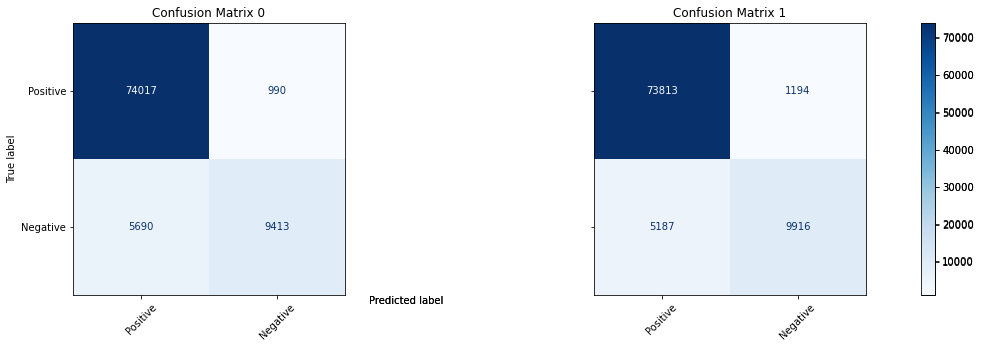

In [45]:
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')

for i, pred in enumerate([predictions_bow, predictions_tfidf]):
    cm = metrics.confusion_matrix(ytest, pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Positive', 'Negative'])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, xticks_rotation=45)
    disp.ax_.set_title('Confusion Matrix ' + str(i))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)

plt.show()

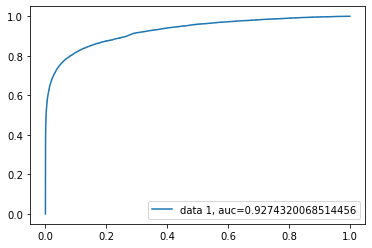

In [46]:
y_pred_proba = lreg.predict_proba(tfidf_features_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

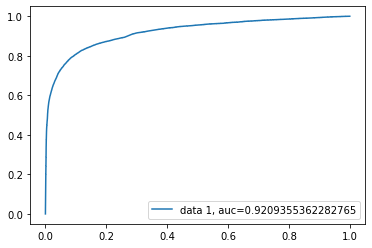

In [47]:
y_pred_proba = lreg.predict_proba(bow_features_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [2]:
tables.display(SCORES_TABLE)

Classifier,Result (.%)
Linear Support Vector Classifier,92.5 %
Logistic Regression,92.4 %
Multinomial Naive Bayes,91.1 %
K-Neighbors Classifier,80.9 %
Random Forest Classifier,92.3 %
Bert Classifier,91.0 %
